In [1]:

!pip install datasets transformers
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset
!pip install scikit-learn
from transformers import EarlyStoppingCallback
import matplotlib.pyplot as plt
import torch
from transformers import EarlyStoppingCallback
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaModel
from transformers import RobertaTokenizer, RobertaForSequenceClassification
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenization

In [2]:
# Load the CSV files

train_df = pd.read_csv('/content/dataset_train_updated.csv')
test_df = pd.read_csv('/content/dataset_test_updated.csv')

# Initialize the tokenizer and model for Clinical Longformer
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-large",
    num_labels=len(train_df['class'].unique())
)
# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding="max_length",
        truncation=True,
        max_length=512
    )

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training

In [3]:
# Split train_df into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['text'], train_df['class'], test_size=0.1, random_state=42
)
# Create DataFrame for validation set
val_df = pd.DataFrame({'text': val_texts, 'class': val_labels})
# Convert to Dataset format
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)
# Tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Rename 'class' to 'labels' explicitly
if 'class' in train_dataset.column_names:
    train_dataset = train_dataset.rename_column('class', 'labels')
if 'class' in val_dataset.column_names:
    val_dataset = val_dataset.rename_column('class', 'labels')
if 'class' in test_dataset.column_names:
    test_dataset = test_dataset.rename_column('class', 'labels')


# Convert to PyTorch format
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Define training arguments with mini-batching (gradient accumulation)
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=20,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=True,
    remove_unused_columns=False
)
# Initialize the EarlyStoppingCallback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3  # Stop training after 3 evaluation steps with no improvement
)


# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  # Validation dataset
    callbacks=[early_stopping_callback]
)

# Train the model
torch.cuda.empty_cache()
trainer.train()

# Save the trained model
model.save_pretrained("roberta_finetuned")

# Save the tokenizer as well
tokenizer.save_pretrained("roberta_finetuned")


Map:   0%|          | 0/398 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
0,0.699400,0.688062
1,0.682200,0.667834
2,0.632400,0.427052
3,0.498200,0.374815
4,0.397900,0.160444
5,0.312300,0.212919
6,0.414800,0.453941
7,0.312900,0.082892
8,0.217000,0.092361
9,0.111900,0.112347


('roberta_finetuned/tokenizer_config.json',
 'roberta_finetuned/special_tokens_map.json',
 'roberta_finetuned/vocab.json',
 'roberta_finetuned/merges.txt',
 'roberta_finetuned/added_tokens.json')

Test Accuracy: 88.00%


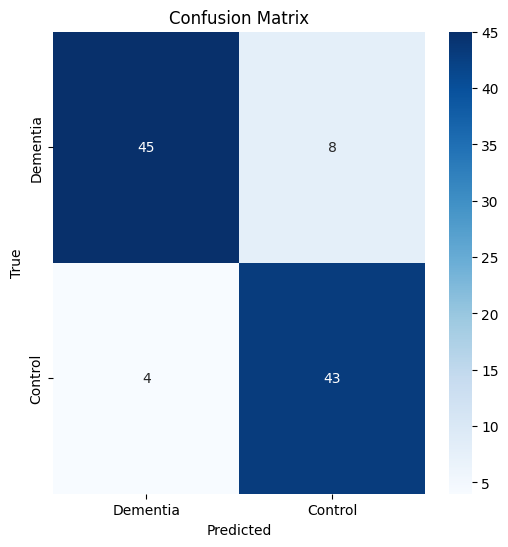

Model training complete, and predictions saved to dataset_test_predictions.csv


In [4]:
# Make predictions on the test dataset
test_predictions = trainer.predict(test_dataset)

# Get the predicted labels (class) from the logits
predicted_labels = torch.argmax(torch.tensor(test_predictions.predictions), axis=-1)

# Add the predictions to the test dataframe
test_df['predicted_class'] = predicted_labels.numpy()

# Calculate accuracy
true_labels = test_df['class'].values
accuracy = accuracy_score(true_labels, predicted_labels.numpy())
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels.numpy())

# Display the confusion matrix using a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Dementia", "Control"], yticklabels=["Dementia", "Control"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save the predictions with accuracy
test_df.to_csv('dataset_test_predictions.csv', index=False)

print("Model training complete, and predictions saved to dataset_test_predictions.csv")